Let's import the required libraries.

In [1]:
!pip install scikit-learn --upgrade --quiet
!pip install xgboost --upgrade --quiet

     |████████████████████████████████| 255.9 MB 39 kB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount(mountpoint='/content/drive')

Mounted at /content/drive


In [4]:
from IPython.display import display

In [5]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [6]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [7]:
from tqdm import tqdm

In [8]:
from xgboost import XGBClassifier

In [9]:
import codecs
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shutil
import random as r

Reading the data.

In [10]:
data_filename = '/content/drive/MyDrive/Applied-AI/Assignment-16/data/main-data/all_bytes_asm_data.csv'

In [11]:
data_df = pd.read_csv(filepath_or_buffer=data_filename)
display(data_df.head())

,ID,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,ASM_Size,Class
0,01kcPWA9K2BOxQeS5Rju,3.0,0.0,1.0,3.0,1.0,0.0,4.0,1.0,3.0,...,66,15,43,83,0,17,48,29,0.078190,1
1,04EjIdbPV5e1XroFOpiN,2.0,2.0,2.0,2.0,2.0,0.0,3.0,0.0,2.0,...,5013,3960,6382,717,0,27,0,88,4.243397,1
2,05EeG39MTRrI6VY21DPd,0.0,0.0,0.0,2.0,0.0,0.0,1.0,6.0,1.0,...,1378,610,446,732,0,20,45,85,0.935457,1
3,05rJTUWYAKNegBk2wE8X,0.0,2.0,1.0,4.0,9.0,1.0,10.0,4.0,4.0,...,15495,16570,28503,2825,0,87,0,491,12.703107,1
4,0AnoOZDNbPXIr2MRBSCJ,2.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,4.0,...,1558,1250,930,851,0,14,0,66,0.891982,1


In [12]:
def class_distribution(data, label, title='Data'):
    """
    This function plots the distribution of given data[label].
    """
    class_val_counts = data[label].value_counts().to_frame()
    percents = class_val_counts.apply(lambda x: round((x / data.shape[0]) * 100, 2))
    class_val_counts['Percentage'] = percents
    display(class_val_counts)
    
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=class_val_counts.index, y=class_val_counts[label])
    for bar in bars.patches:
        bars.annotate(s=format(bar.get_height()),
                      xy=((bar.get_x() + bar.get_width() / 2), bar.get_height()),
                      ha='center',
                      va='center',
                      size=10,
                      xytext=(0, 6),
                      textcoords='offset points')
    plt.xlabel(xlabel=label)
    plt.ylabel(ylabel='Value Counts')
    plt.title(label=title)
    plt.grid()
    plt.show()

,Class,Percentage
3,2942,27.07
2,2478,22.80
1,1541,14.18
8,1228,11.30
9,1013,9.32
6,751,6.91
4,475,4.37
7,398,3.66
5,42,0.39


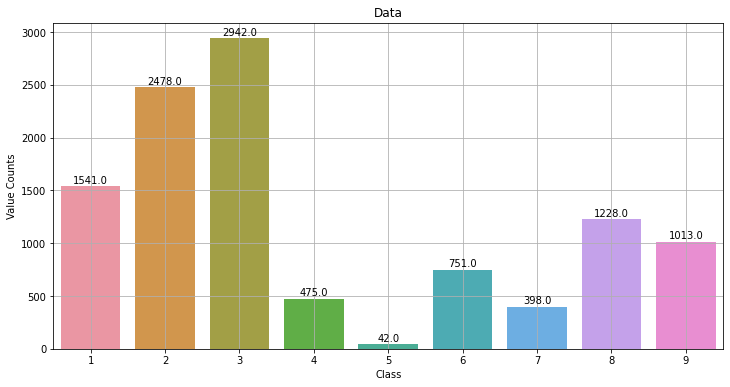

In [13]:
class_distribution(data=data_df, label='Class')

In [14]:
y_all = data_df['Class'].values
print(y_all)

[1 1 1 ... 9 9 9]


Normalization.

In [15]:
train_columns = list(data_df.columns)
train_columns.remove('ID')
train_columns.remove('Class')

In [16]:
tSNE_result = StandardScaler().fit_transform(data_df[train_columns])
print(tSNE_result[:5])

[[-0.33608535 -0.70419452 -0.57023792 ...  0.03338963 -0.39331339
  -0.56488778]
 [-0.48002354 -0.42755667 -0.43350361 ... -0.04137383 -0.14293438
  -0.38146845]
 [-0.76789993 -0.70419452 -0.70697222 ...  0.02871691 -0.15566551
  -0.52713709]
 [-0.76789993 -0.42755667 -0.57023792 ... -0.04137383  1.56728159
  -0.00893611]
 [-0.48002354 -0.5658756  -0.57023792 ... -0.04137383 -0.23629604
  -0.52905157]]


Reference: https://stackoverflow.com/a/72048359/7579443

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.nan_to_num.html

In [17]:
tSNE_result = np.nan_to_num(x=tSNE_result)

Multivariate analysis.

In [18]:
def plot_tSNE(perplexity, matrix, y_all):
    """
    Plots the tSNE.
    """
    xtSNE = TSNE(perplexity=50)
    xtSNE_result = xtSNE.fit_transform(X=matrix)
    vis_x = xtSNE_result[:, 0]
    vis_y = xtSNE_result[:, 1]
    
    plt.figure(figsize=(15, 8))
    plt.scatter(x=vis_x, y=vis_y, c=y_all, cmap=plt.cm.get_cmap('jet', 9))
    plt.colorbar()
    plt.clim(vmin=1, vmax=9)
    plt.show()

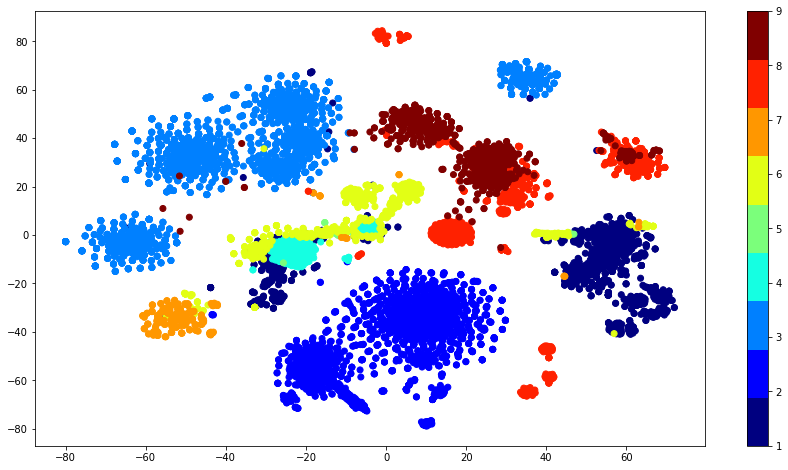

In [19]:
plot_tSNE(perplexity=50, matrix=tSNE_result, y_all=y_all)

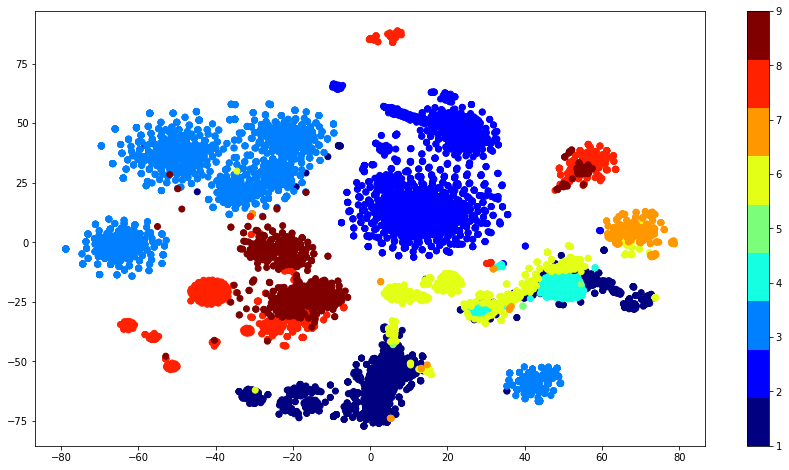

In [20]:
plot_tSNE(perplexity=30, matrix=tSNE_result, y_all=y_all)

Train and test split.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(tSNE_result, y_all, stratify=y_all, test_size=0.20)

In [22]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

In [23]:
print("The shape of train data: {}.".format(X_train.shape))
print("The shape of cross validation data: {}.".format(X_cv.shape))
print("The shape of test data: {}.".format(X_test.shape))

The shape of train data: (6955, 3110).
The shape of cross validation data: (1739, 3110).
The shape of test data: (2174, 3110).


Confusion matrix.

In [24]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    """
    plt.figure(figsize=(14, 7))
    sns.heatmap(data=matrix,
                annot=True,
                fmt='.2f',
                linewidths=0.1,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(label=title)
    plt.show()

In [25]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    pmat = cmat / cmat.sum(axis=0) # axis = 0: consider all the rows in each column
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T)/(cmat.sum(axis=1).T)).T # axis = 1: consider all the columns in each row
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)

Random model.

In [26]:
labels = list(range(1, 10))

In [27]:
def build_random_model(X_train, X_cv, X_test, y_train, y_cv, y_test, labels):
    """
    This function builds the random model.
    """
    dummy_clf = DummyClassifier(strategy='uniform')
    dummy_clf.fit(X=X_train, y=y_train)
    
    train_pred = dummy_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, eps=1e-15)
    train_loss = round(train_loss, 3)
    train_cm_pred = dummy_clf.predict(X=X_train)
    print("Train")
    print("Log Loss (Train): {}".format(train_loss))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=labels)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = dummy_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, eps=1e-15)
    cv_loss = round(cv_loss, 3)
    cv_cm_pred = dummy_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Log Loss (CV): {}".format(cv_loss))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=labels)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = dummy_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, eps=1e-15)
    test_loss = round(test_loss, 3)
    test_cm_pred = dummy_clf.predict(X=X_test)
    print("\nTest")
    print("Log Loss (Test): {}".format(test_loss))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=labels)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return train_loss, cv_loss, test_loss

Train
Log Loss (Train): 2.197
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


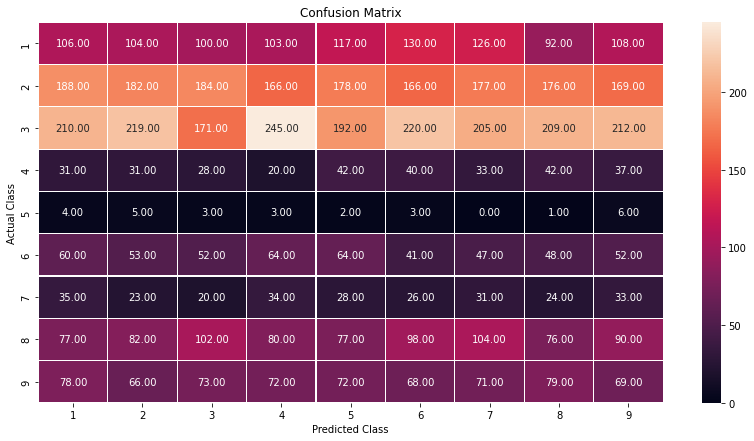

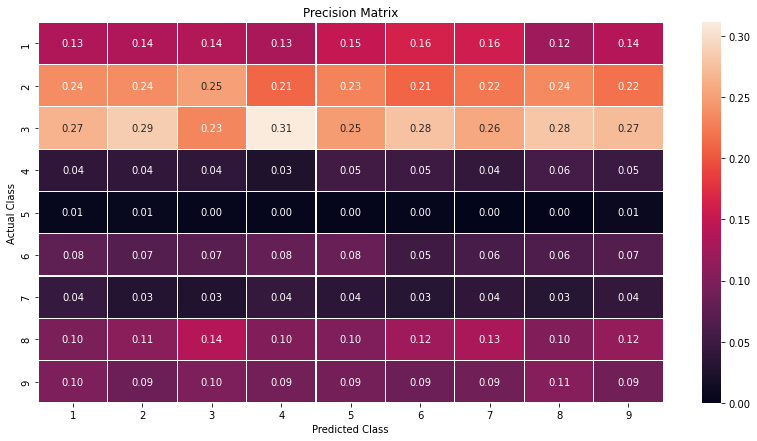

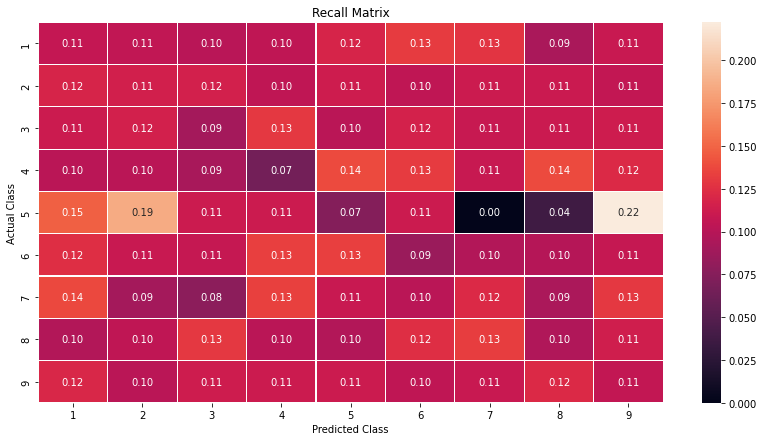

              precision    recall  f1-score   support

           1       0.13      0.11      0.12       986
           2       0.24      0.11      0.15      1586
           3       0.23      0.09      0.13      1883
           4       0.03      0.07      0.04       304
           5       0.00      0.07      0.01        27
           6       0.05      0.09      0.06       481
           7       0.04      0.12      0.06       254
           8       0.10      0.10      0.10       786
           9       0.09      0.11      0.10       648

    accuracy                           0.10      6955
   macro avg       0.10      0.10      0.09      6955
weighted avg       0.16      0.10      0.12      6955


Cross Validation
Log Loss (CV): 2.197
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


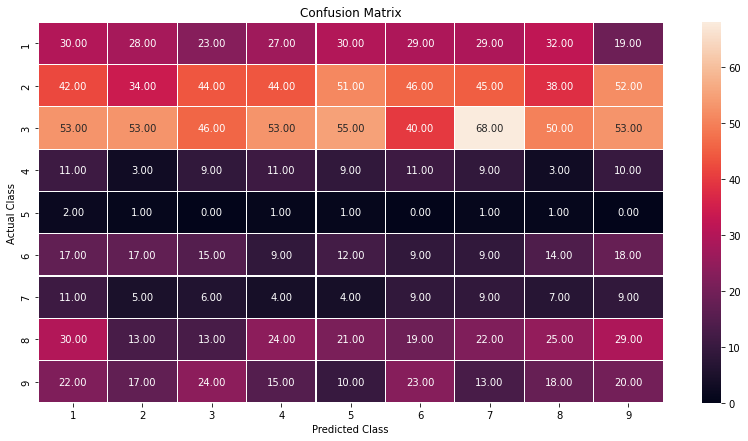

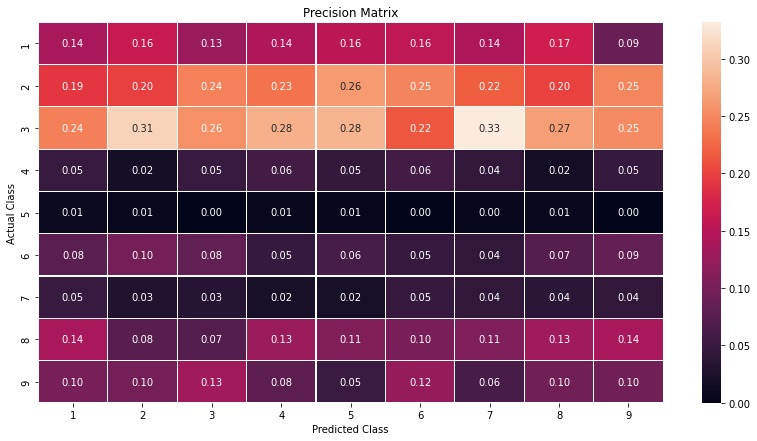

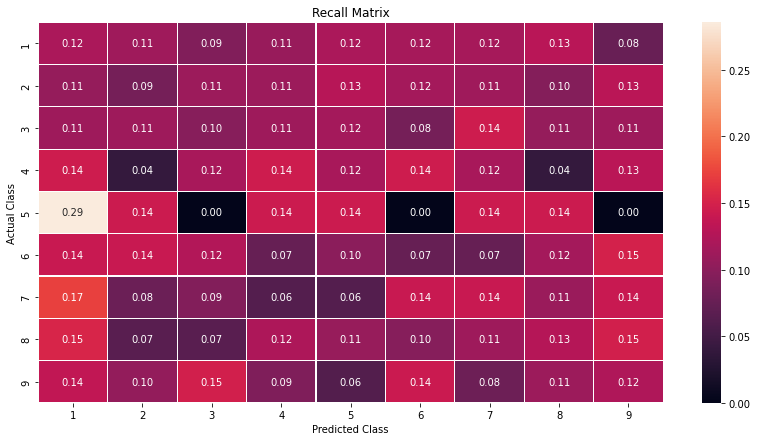

              precision    recall  f1-score   support

           1       0.14      0.12      0.13       247
           2       0.20      0.09      0.12       396
           3       0.26      0.10      0.14       471
           4       0.06      0.14      0.08        76
           5       0.01      0.14      0.01         7
           6       0.05      0.07      0.06       120
           7       0.04      0.14      0.07        64
           8       0.13      0.13      0.13       196
           9       0.10      0.12      0.11       162

    accuracy                           0.11      1739
   macro avg       0.11      0.12      0.09      1739
weighted avg       0.17      0.11      0.12      1739


Test
Log Loss (Test): 2.197
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


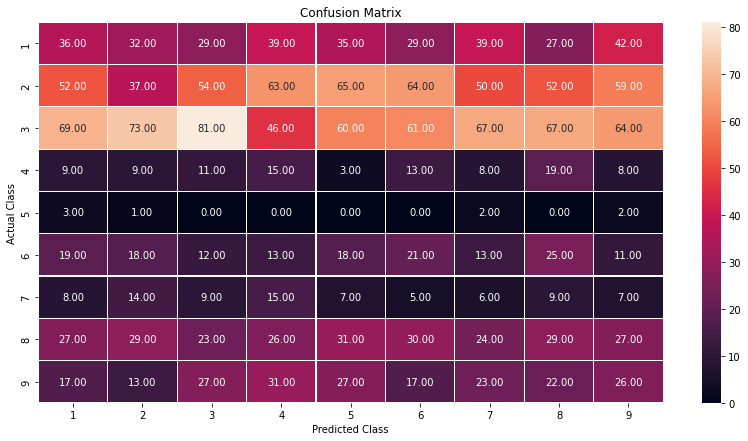

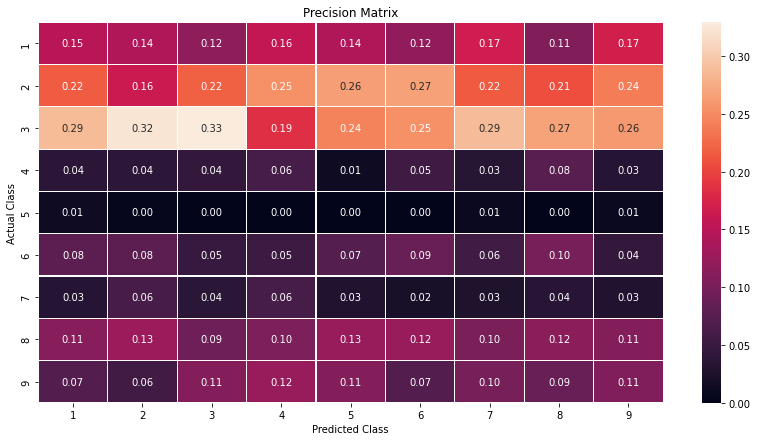

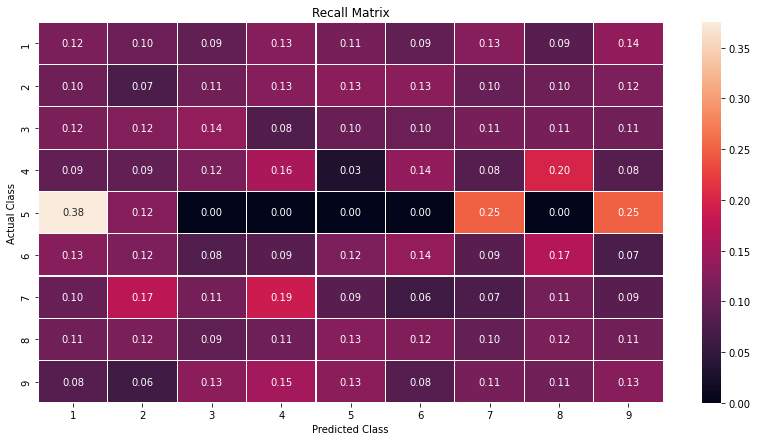

              precision    recall  f1-score   support

           1       0.15      0.12      0.13       308
           2       0.16      0.07      0.10       496
           3       0.33      0.14      0.19       588
           4       0.06      0.16      0.09        95
           5       0.00      0.00      0.00         8
           6       0.09      0.14      0.11       150
           7       0.03      0.07      0.04        80
           8       0.12      0.12      0.12       246
           9       0.11      0.13      0.12       203

    accuracy                           0.12      2174
   macro avg       0.12      0.11      0.10      2174
weighted avg       0.18      0.12      0.13      2174



In [28]:
rm_train_loss, rm_cv_loss, rm_test_loss = build_random_model(X_train=X_train,
                                                             X_cv=X_cv,
                                                             X_test=X_test,
                                                             y_train=y_train,
                                                             y_cv=y_cv,
                                                             y_test=y_test,
                                                             labels=labels)

KNN classifier.

In [29]:
def build_knn_classifier_model(X_train,
                               X_cv,
                               X_test,
                               y_train,
                               y_cv,
                               y_test,
                               hparams,
                               logify=False):
    """
    This function builds the classifier.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    for i in hparams:
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['alpha'] = hparams
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    plt.figure(figsize=(10, 6))
    plt.plot(hparams_logs, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(s=(hparams[i], txt), xy=(hparams_logs[i], log_error_list[i]))
    plt.xticks(hparams_logs)
    plt.title(label='CV Error vs Alpha')
    plt.xlabel("Parameters")
    plt.ylabel('Error Measure')
    plt.grid()
    plt.show()
    
    best_param = hparams[np.argmin(log_error_list)]
    clf = KNeighborsClassifier(n_neighbors=best_param)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_loss = round(train_loss, 3)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_loss = round(cv_loss, 3)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    miss_cv = round(miss_cv*100, 2)
    print("The % of missclassified points in cross validation data: {}%".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_loss = round(test_loss, 3)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    miss_test = round(miss_test*100, 2)
    print("The % of missclassified points in test data: {}%".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return train_loss, cv_loss, test_loss

Hyperparameter Tuning


,alpha,logloss
0,1,0.154842
1,3,0.149725
2,5,0.146552
3,7,0.156828
4,9,0.167234
5,11,0.176325
6,13,0.183700


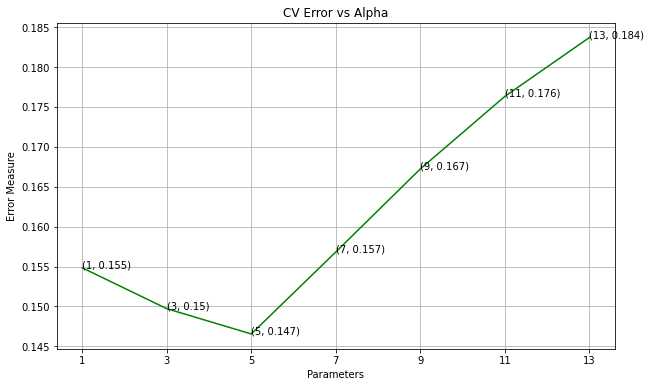

Train
Logloss (Train): 0.103 for best param: 5
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


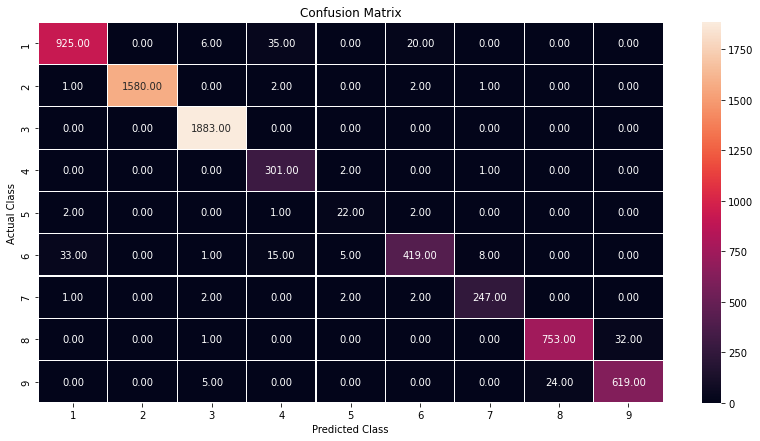

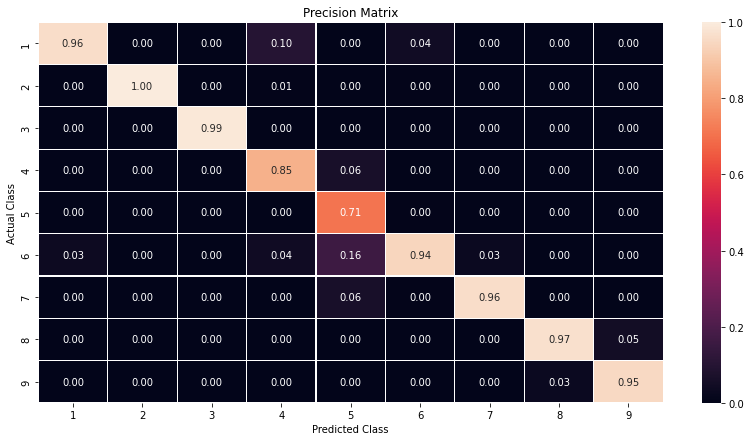

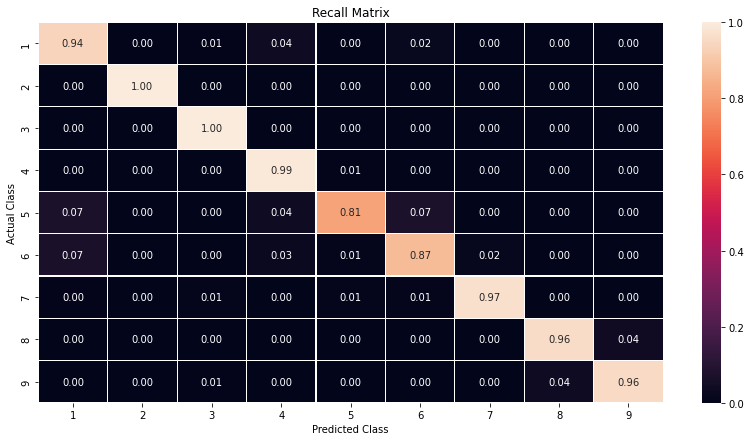

              precision    recall  f1-score   support

           1       0.96      0.94      0.95       986
           2       1.00      1.00      1.00      1586
           3       0.99      1.00      1.00      1883
           4       0.85      0.99      0.91       304
           5       0.71      0.81      0.76        27
           6       0.94      0.87      0.90       481
           7       0.96      0.97      0.97       254
           8       0.97      0.96      0.96       786
           9       0.95      0.96      0.95       648

    accuracy                           0.97      6955
   macro avg       0.93      0.94      0.93      6955
weighted avg       0.97      0.97      0.97      6955


Cross Validation
Logloss (CV): 0.147 for best param: 5
The % of missclassified points in cross validation data: 3.68%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


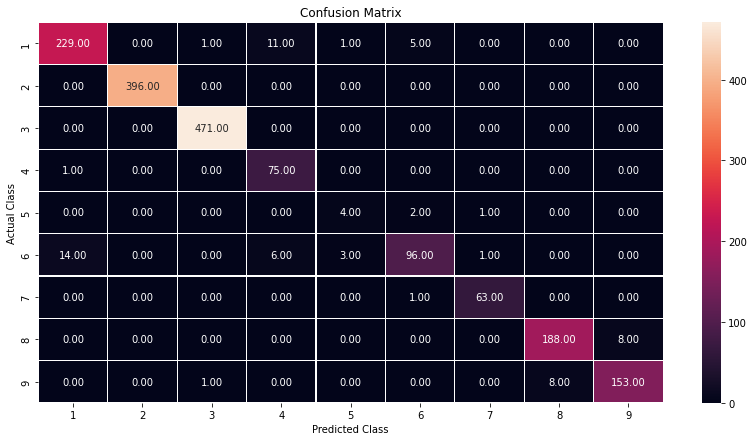

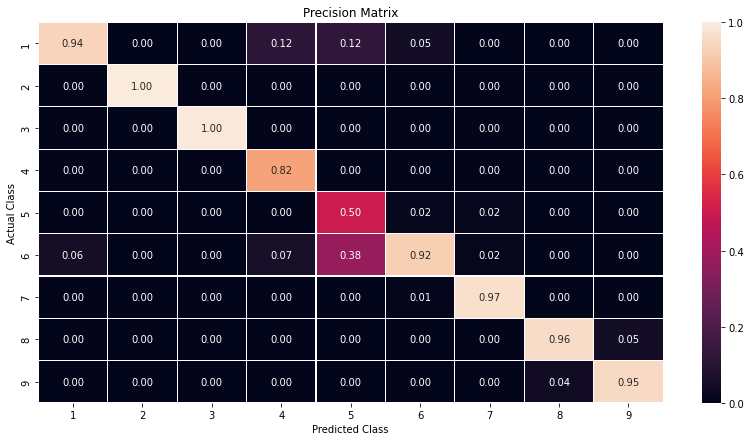

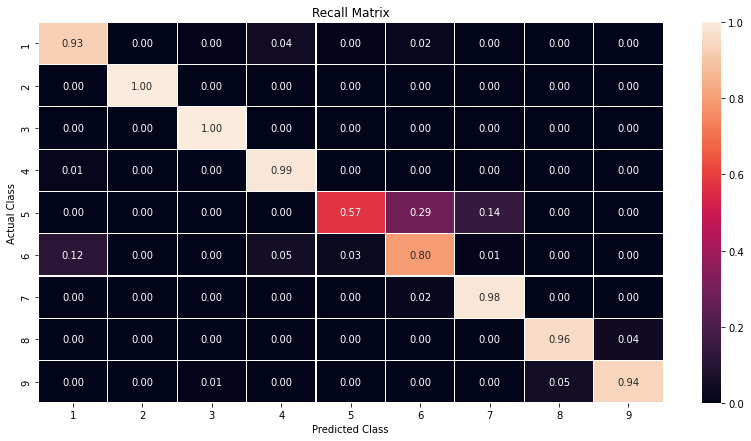

              precision    recall  f1-score   support

           1       0.94      0.93      0.93       247
           2       1.00      1.00      1.00       396
           3       1.00      1.00      1.00       471
           4       0.82      0.99      0.89        76
           5       0.50      0.57      0.53         7
           6       0.92      0.80      0.86       120
           7       0.97      0.98      0.98        64
           8       0.96      0.96      0.96       196
           9       0.95      0.94      0.95       162

    accuracy                           0.96      1739
   macro avg       0.89      0.91      0.90      1739
weighted avg       0.96      0.96      0.96      1739


Test
Logloss (Test): 0.139 for best param: 5
The % of missclassified points in test data: 3.31%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


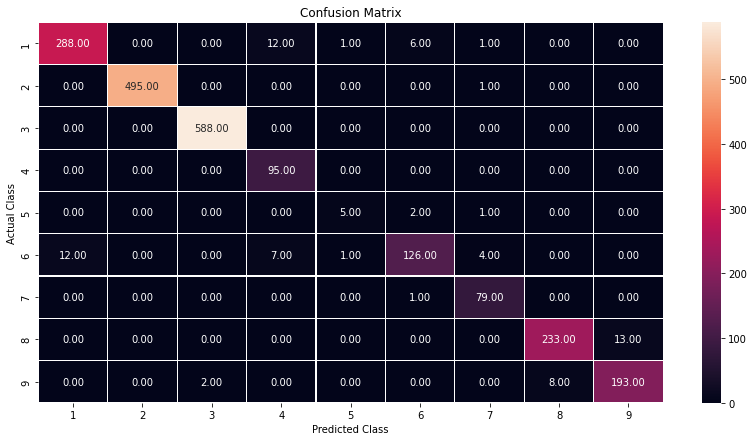

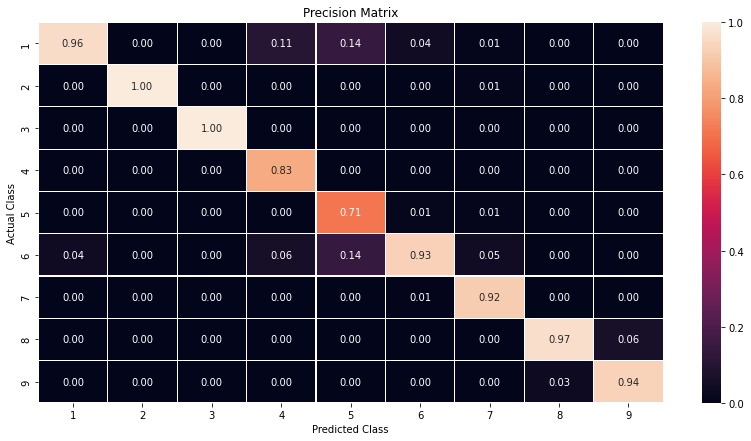

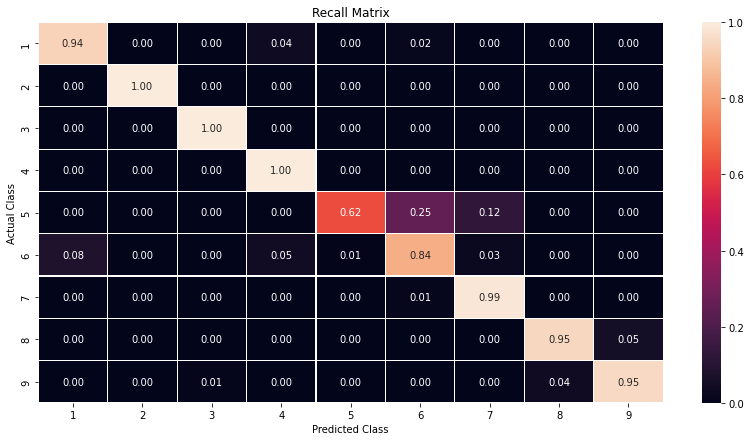

              precision    recall  f1-score   support

           1       0.96      0.94      0.95       308
           2       1.00      1.00      1.00       496
           3       1.00      1.00      1.00       588
           4       0.83      1.00      0.91        95
           5       0.71      0.62      0.67         8
           6       0.93      0.84      0.88       150
           7       0.92      0.99      0.95        80
           8       0.97      0.95      0.96       246
           9       0.94      0.95      0.94       203

    accuracy                           0.97      2174
   macro avg       0.92      0.92      0.92      2174
weighted avg       0.97      0.97      0.97      2174



In [30]:
neighbor_params = [x for x in range(1, 15, 2)]
knn_train_loss, knn_cv_loss, knn_test_loss = build_knn_classifier_model(X_train=X_train,
                                                                        X_cv=X_cv,
                                                                        X_test=X_test,
                                                                        y_train=y_train,
                                                                        y_cv=y_cv,
                                                                        y_test=y_test,
                                                                        hparams=neighbor_params,
                                                                        logify=False)

Logistic regression.

In [31]:
def build_linear_model(X_train,
                       X_cv,
                       X_test,
                       y_train,
                       y_cv,
                       y_test,
                       loss_type,
                       hparams,
                       balancing=True,
                       logify=False):
    """
    This function builds the linear model.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    pbd = 'balanced' if balancing else None
    
    for i in hparams:
        clf = SGDClassifier(loss=loss_type, alpha=i, class_weight=pbd, random_state=42)
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['alpha'] = hparams
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    hparams_logs = np.log10(hparams) if logify else hparams
    
    plt.figure(figsize=(10, 6))
    plt.plot(hparams_logs, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(s=(hparams[i], txt), xy=(hparams_logs[i], log_error_list[i]))
    plt.xticks(hparams_logs)
    plt.title(label='CV Error vs Alpha')
    plt.xlabel("Parameters")
    plt.ylabel('Error Measure')
    plt.grid()
    plt.show()
    
    best_param = hparams[np.argmin(log_error_list)]
    clf = SGDClassifier(loss=loss_type, alpha=best_param, class_weight=pbd, random_state=42)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_loss = round(train_loss, 3)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_loss = round(cv_loss, 3)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    miss_cv = round(miss_cv*100, 2)
    print("The % of missclassified points in cross validation data: {}%".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_loss = round(test_loss, 3)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    miss_test = round(miss_test*100, 2)
    print("The % of missclassified points in test data: {}%".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return train_loss, cv_loss, test_loss

Hyperparameter Tuning


,alpha,logloss
0,0.000001,0.832141
1,0.000010,0.218893
2,0.000100,0.247704
3,0.001000,0.298531
4,0.010000,0.246004
5,0.100000,0.186051
6,1.000000,0.247052
7,10.000000,0.339498
8,100.000000,0.427828
9,1000.000000,0.528321


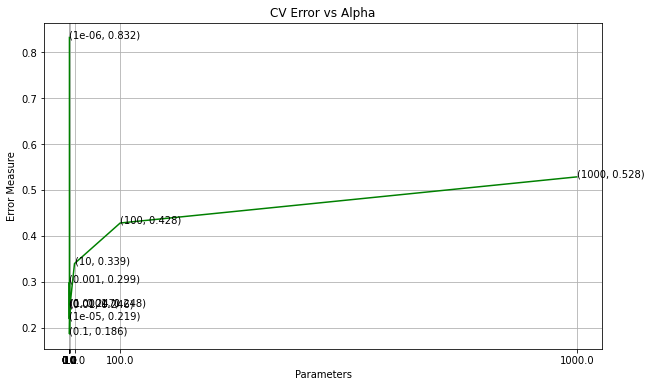

Train
Logloss (Train): 0.161 for best param: 0.1
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


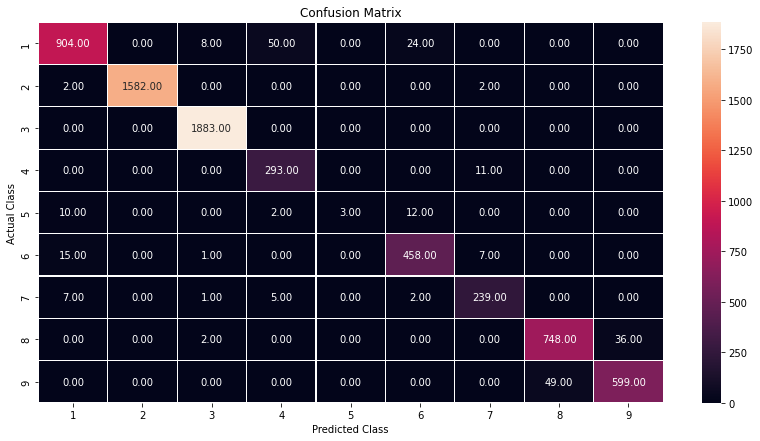

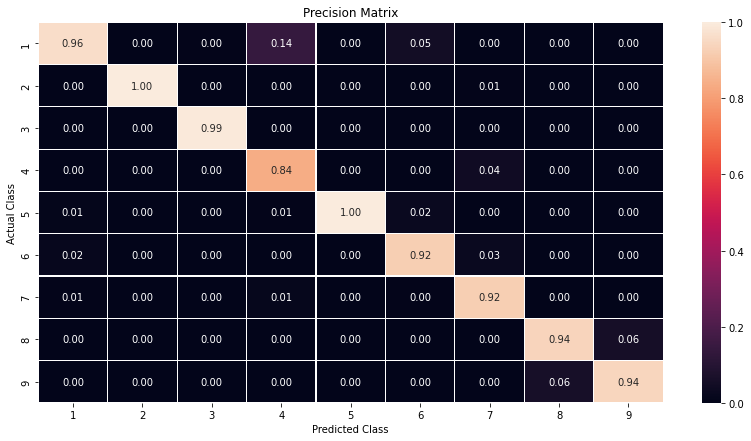

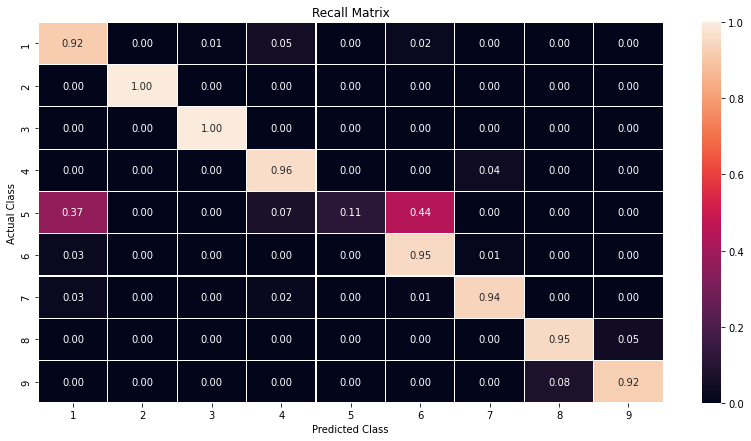

              precision    recall  f1-score   support

           1       0.96      0.92      0.94       986
           2       1.00      1.00      1.00      1586
           3       0.99      1.00      1.00      1883
           4       0.84      0.96      0.90       304
           5       1.00      0.11      0.20        27
           6       0.92      0.95      0.94       481
           7       0.92      0.94      0.93       254
           8       0.94      0.95      0.95       786
           9       0.94      0.92      0.93       648

    accuracy                           0.96      6955
   macro avg       0.95      0.86      0.86      6955
weighted avg       0.97      0.96      0.96      6955


Cross Validation
Logloss (CV): 0.186 for best param: 0.1
The % of missclassified points in cross validation data: 4.26%
Column sum of precision matrix: [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


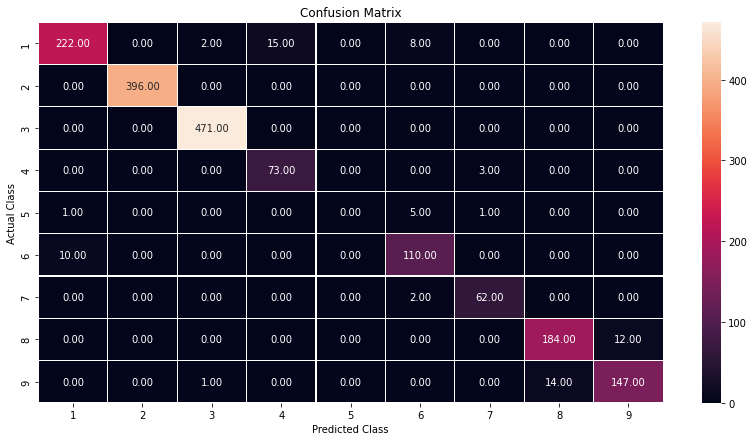

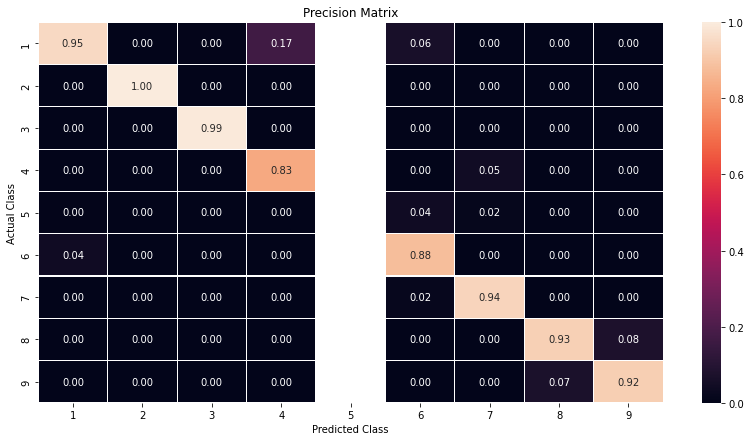

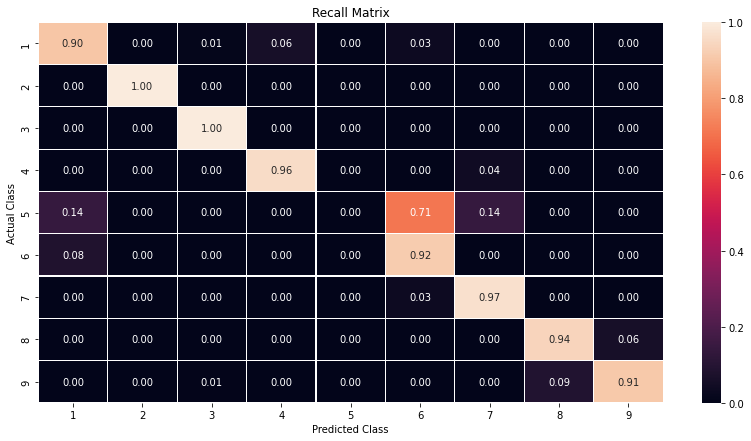

              precision    recall  f1-score   support

           1       0.95      0.90      0.93       247
           2       1.00      1.00      1.00       396
           3       0.99      1.00      1.00       471
           4       0.83      0.96      0.89        76
           5       0.00      0.00      0.00         7
           6       0.88      0.92      0.90       120
           7       0.94      0.97      0.95        64
           8       0.93      0.94      0.93       196
           9       0.92      0.91      0.92       162

    accuracy                           0.96      1739
   macro avg       0.83      0.84      0.83      1739
weighted avg       0.95      0.96      0.96      1739


Test
Logloss (Test): 0.189 for best param: 0.1
The % of missclassified points in test data: 4.37%
Column sum of precision matrix: [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


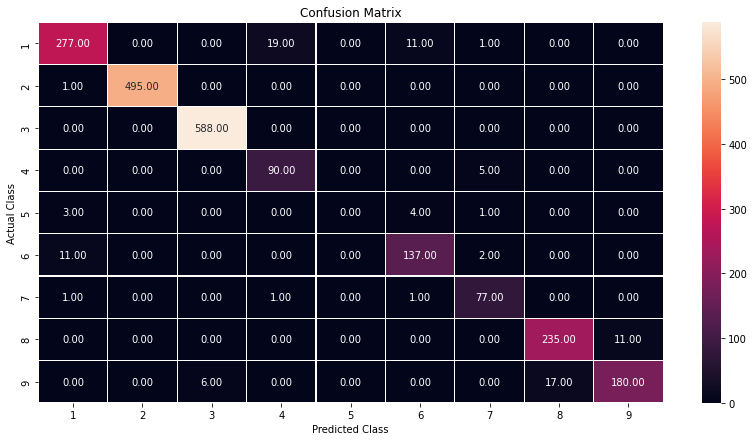

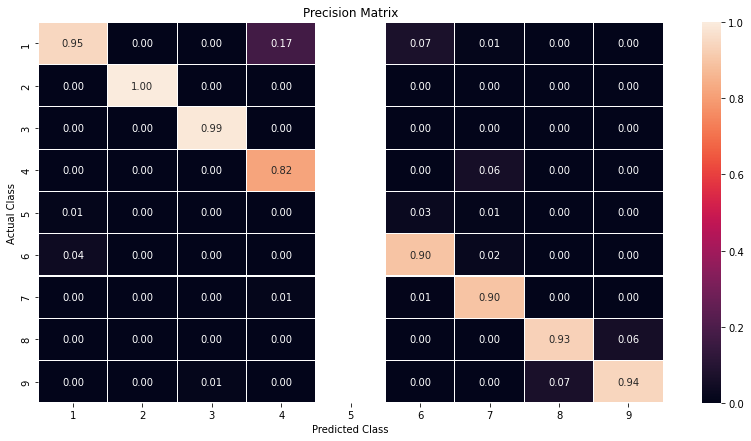

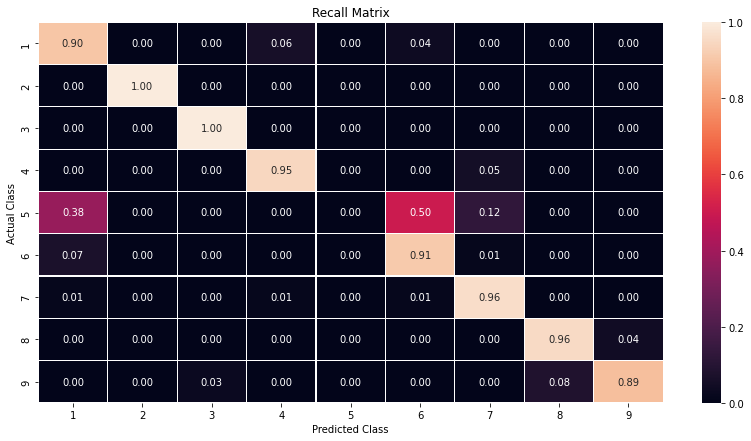

              precision    recall  f1-score   support

           1       0.95      0.90      0.92       308
           2       1.00      1.00      1.00       496
           3       0.99      1.00      0.99       588
           4       0.82      0.95      0.88        95
           5       0.00      0.00      0.00         8
           6       0.90      0.91      0.90       150
           7       0.90      0.96      0.93        80
           8       0.93      0.96      0.94       246
           9       0.94      0.89      0.91       203

    accuracy                           0.96      2174
   macro avg       0.82      0.84      0.83      2174
weighted avg       0.95      0.96      0.95      2174



In [32]:
alpha_params = [10 ** x for x in range(-6, 4)]
lr_train_loss, lr_cv_loss, lr_test_loss = build_linear_model(X_train=X_train,
                                                             X_cv=X_cv,
                                                             X_test=X_test,
                                                             y_train=y_train,
                                                             y_cv=y_cv,
                                                             y_test=y_test,
                                                             loss_type='log',
                                                             hparams=alpha_params,
                                                             logify=False,
                                                             balancing=True)

Random forest classifier.

In [33]:
def build_tree_classifier(X_train,
                          X_cv,
                          X_test,
                          y_train,
                          y_cv,
                          y_test,
                          estimators_params):
    """
    This function builds the tree classifier.
    """
    log_error_list = list()
    estimator_list = list()
    loss_df = pd.DataFrame()
    
    for i in estimators_params:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', random_state=42, n_jobs=-1)
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        estimator_list.append(i)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['estimator'] = estimator_list
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(estimator_list, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(s=(estimator_list[i], txt), xy=(estimator_list[i], log_error_list[i]))
    plt.xticks(estimator_list)
    plt.title(label='CV Error vs Estimator')
    plt.xlabel("Parameters")
    plt.ylabel('Error Measure')
    plt.grid()
    plt.show()
    
    best_param = np.argmin(log_error_list)
    best_estimator = estimators_params[best_param]
    clf = RandomForestClassifier(n_estimators=best_estimator, criterion='gini', random_state=42, n_jobs=-1)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_loss = round(train_loss, 3)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_loss = round(cv_loss, 3)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    miss_cv = round(miss_cv*100, 2)
    print("The % of missclassified points in cross validation data: {}%".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_loss = round(test_loss, 3)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    miss_test = round(miss_test*100, 2)
    print("The % of missclassified points in test data: {}%".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return train_loss, cv_loss, test_loss

Hyperparameter Tuning


,estimator,logloss
0,10,0.042109
1,50,0.038126
2,100,0.037789
3,500,0.036416
4,1000,0.036431
5,2000,0.036447
6,3000,0.036477


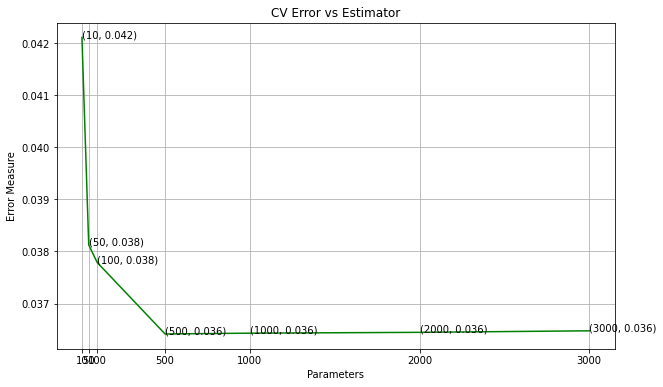

Train
Logloss (Train): 0.013 for best param: 3
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


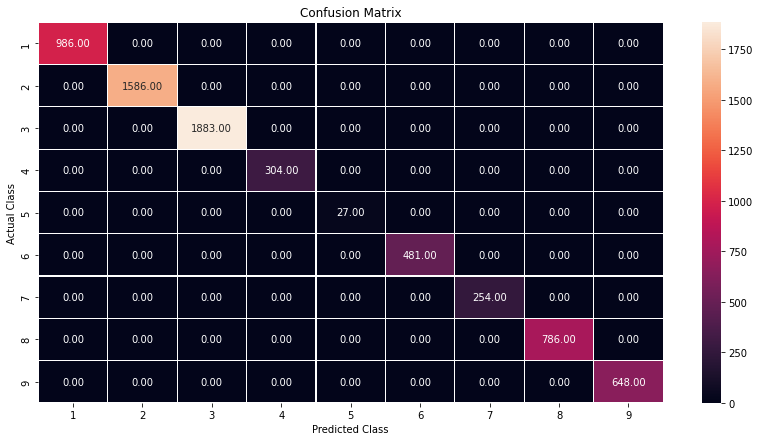

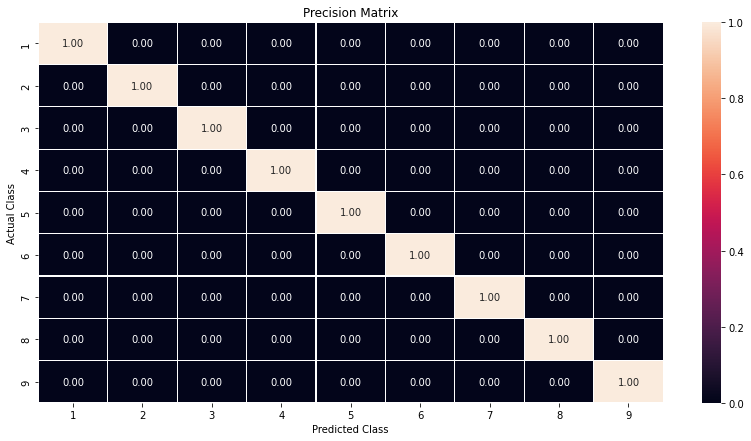

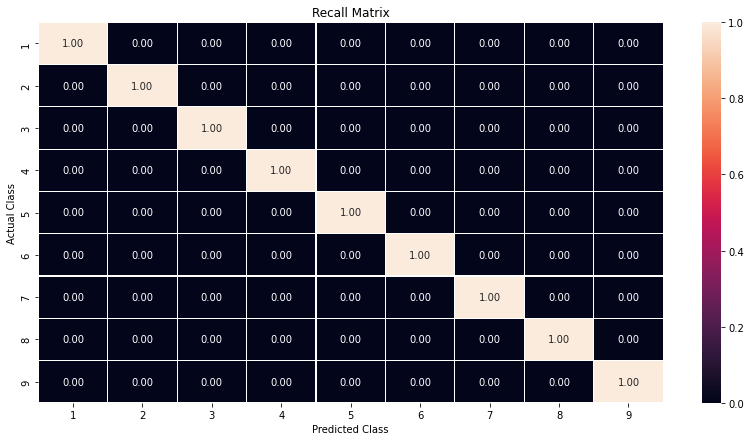

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       986
           2       1.00      1.00      1.00      1586
           3       1.00      1.00      1.00      1883
           4       1.00      1.00      1.00       304
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00       481
           7       1.00      1.00      1.00       254
           8       1.00      1.00      1.00       786
           9       1.00      1.00      1.00       648

    accuracy                           1.00      6955
   macro avg       1.00      1.00      1.00      6955
weighted avg       1.00      1.00      1.00      6955


Cross Validation
Logloss (CV): 0.036 for best param: 3
The % of missclassified points in cross validation data: 0.75%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


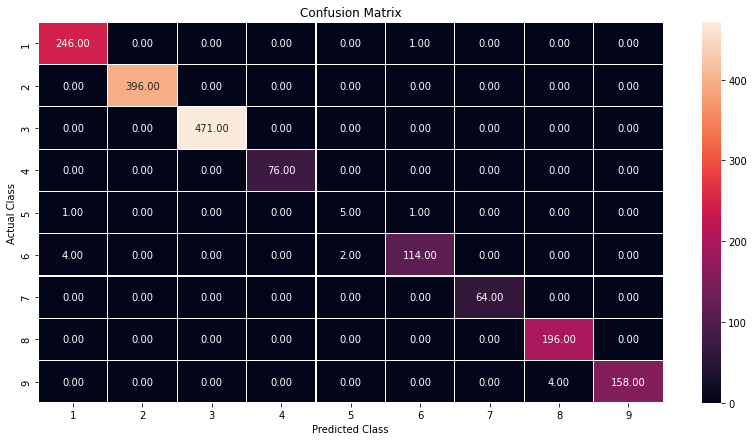

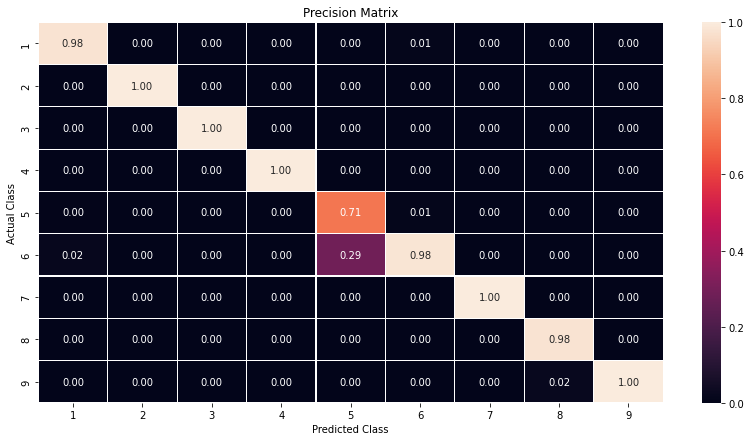

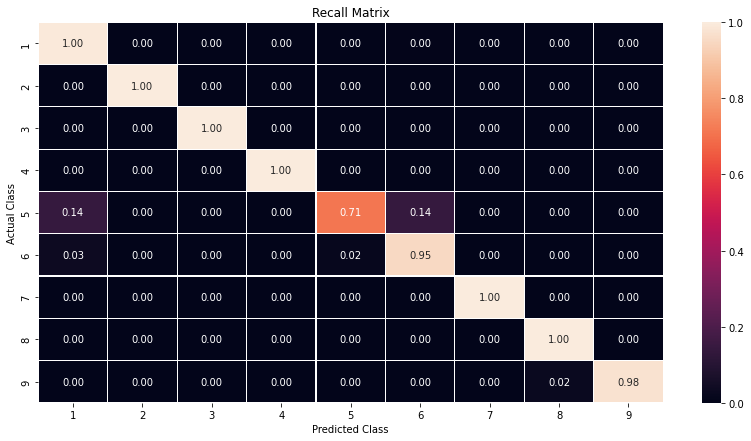

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       247
           2       1.00      1.00      1.00       396
           3       1.00      1.00      1.00       471
           4       1.00      1.00      1.00        76
           5       0.71      0.71      0.71         7
           6       0.98      0.95      0.97       120
           7       1.00      1.00      1.00        64
           8       0.98      1.00      0.99       196
           9       1.00      0.98      0.99       162

    accuracy                           0.99      1739
   macro avg       0.96      0.96      0.96      1739
weighted avg       0.99      0.99      0.99      1739


Test
Logloss (Test): 0.031 for best param: 3
The % of missclassified points in test data: 0.64%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


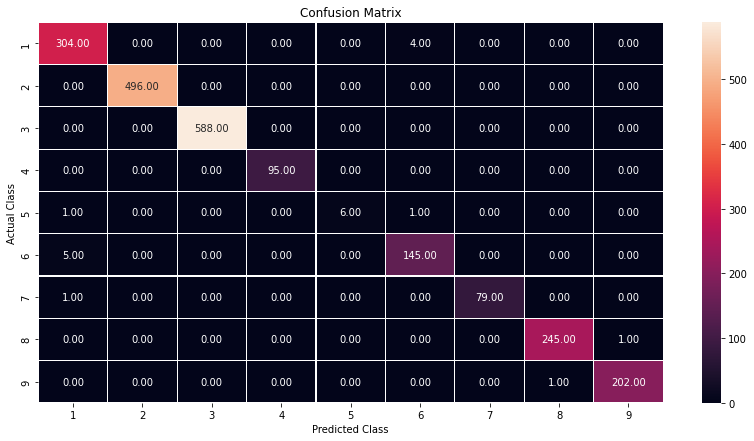

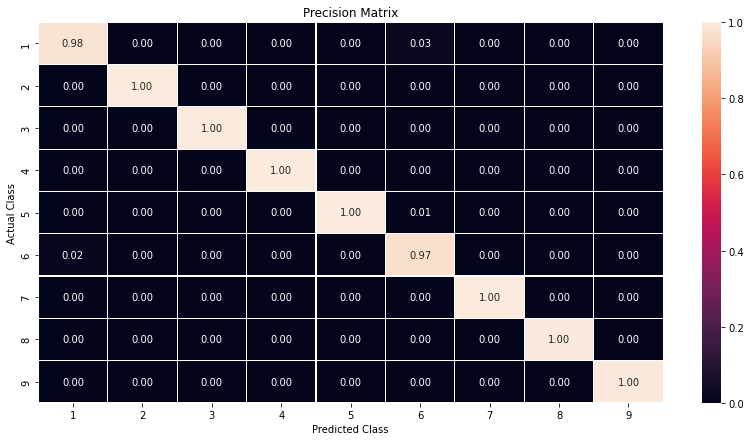

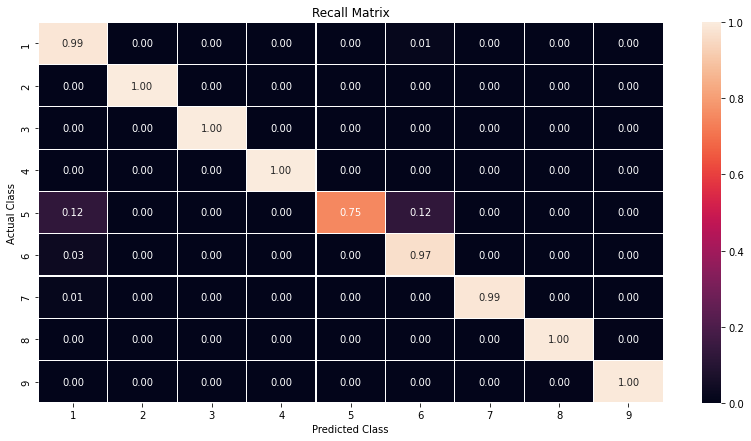

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       308
           2       1.00      1.00      1.00       496
           3       1.00      1.00      1.00       588
           4       1.00      1.00      1.00        95
           5       1.00      0.75      0.86         8
           6       0.97      0.97      0.97       150
           7       1.00      0.99      0.99        80
           8       1.00      1.00      1.00       246
           9       1.00      1.00      1.00       203

    accuracy                           0.99      2174
   macro avg       0.99      0.96      0.98      2174
weighted avg       0.99      0.99      0.99      2174



In [34]:
estimators_params = [10, 50, 100, 500, 1000, 2000, 3000]
rf_train_loss, rf_cv_loss, rf_test_loss = build_tree_classifier(X_train=X_train,
                                                                X_cv=X_cv,
                                                                X_test=X_test,
                                                                y_train=y_train,
                                                                y_cv=y_cv,
                                                                y_test=y_test,
                                                                estimators_params=estimators_params)

XGBoost classifier.

In [41]:
def build_gb_classifier(X_train,
                        X_cv,
                        X_test,
                        y_train,
                        y_cv,
                        y_test,
                        estimators_params):
    """
    This function builds the XGBoost classifier.
    """
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_cv = le.fit_transform(y_cv)
    y_test = le.fit_transform(y_test)

    log_error_list = list()
    estimator_list = list()
    loss_df = pd.DataFrame()
    
    for i in tqdm(estimators_params):
        clf = XGBClassifier(n_estimators=i, n_jobs=-1, tree_method='gpu_hist', objective='multi:softproba')
        clf.fit(X=X_train, y=y_train)
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        sig_clf_probs = sig_clf.predict_proba(X=X_cv)
        lloss = log_loss(y_true=y_cv, y_pred=sig_clf_probs, eps=1e-15)
        estimator_list.append(i)
        log_error_list.append(lloss)
    
    print("Hyperparameter Tuning")
    loss_df['estimator'] = estimator_list
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(estimator_list, log_error_list, c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(s=(estimator_list[i], txt), xy=(estimator_list[i], log_error_list[i]))
    plt.xticks(estimator_list)
    plt.title(label='CV Error vs Estimator')
    plt.xlabel("Parameters")
    plt.ylabel('Error Measure')
    plt.grid()
    plt.show()
    
    best_param = np.argmin(log_error_list)
    best_estimator = estimators_params[best_param]
    clf = XGBClassifier(n_estimators=best_estimator, n_jobs=-1, tree_method='gpu_hist', objective='multi:softproba')
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_loss = round(train_loss, 3)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best param: {}".format(train_loss, best_param))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_loss = round(cv_loss, 3)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best param: {}".format(cv_loss, best_param))
    miss_cv = np.count_nonzero(a=(cv_cm_pred - y_cv)) / (y_cv.shape[0])
    miss_cv = round(miss_cv*100, 2)
    print("The % of missclassified points in cross validation data: {}%".format(miss_cv))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_loss = round(test_loss, 3)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best param: {}".format(test_loss, best_param))
    miss_test = np.count_nonzero(a=(test_cm_pred - y_test)) / (y_test.shape[0])
    miss_test = round(miss_test*100, 2)
    print("The % of missclassified points in test data: {}%".format(miss_test))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))
    
    return train_loss, cv_loss, test_loss

100%|██████████| 6/6 [22:25<00:00, 224.20s/it]

Hyperparameter Tuning


,estimator,logloss
0,10,0.047384
1,50,0.042886
2,100,0.042828
3,500,0.042798
4,1000,0.042799
5,2000,0.042796


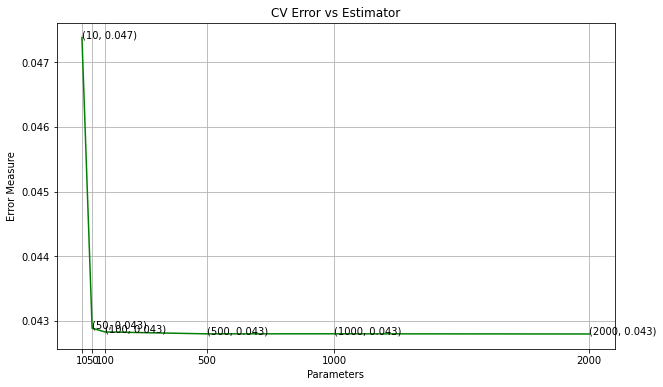

Train
Logloss (Train): 0.011 for best param: 5
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


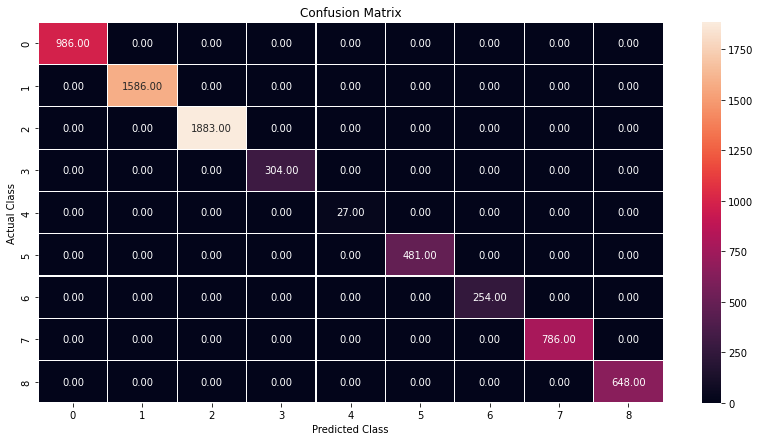

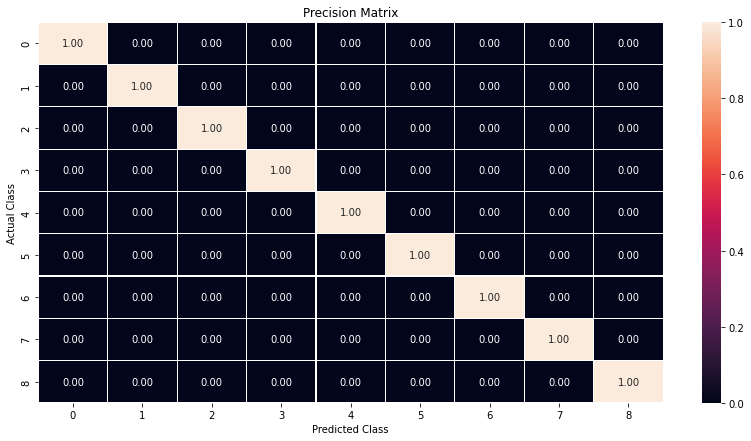

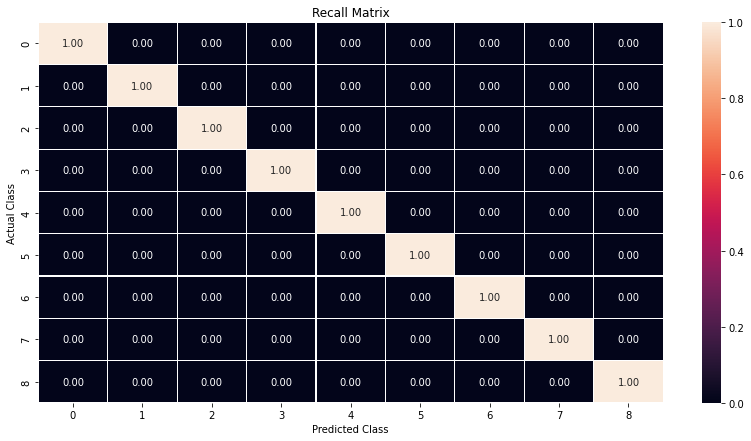

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00      1586
           2       1.00      1.00      1.00      1883
           3       1.00      1.00      1.00       304
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00       481
           6       1.00      1.00      1.00       254
           7       1.00      1.00      1.00       786
           8       1.00      1.00      1.00       648

    accuracy                           1.00      6955
   macro avg       1.00      1.00      1.00      6955
weighted avg       1.00      1.00      1.00      6955


Cross Validation
Logloss (CV): 0.043 for best param: 5
The % of missclassified points in cross validation data: 0.63%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


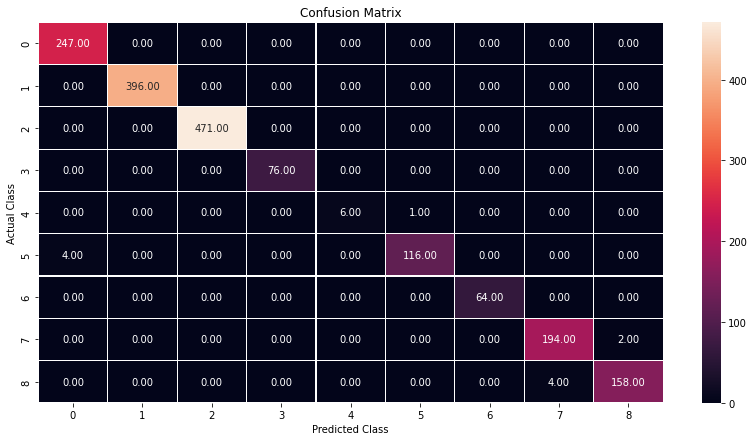

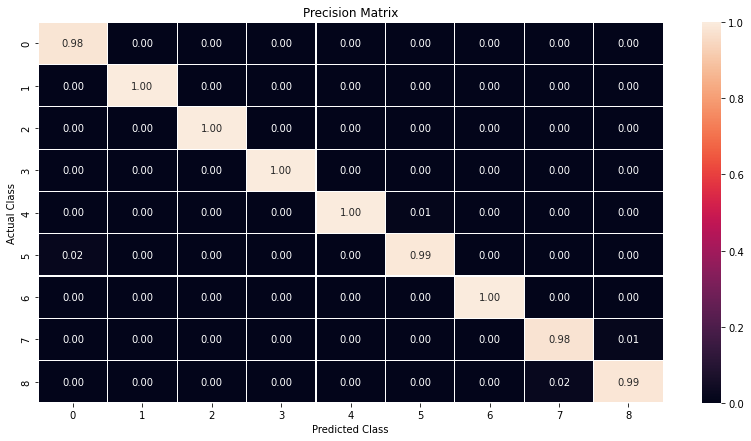

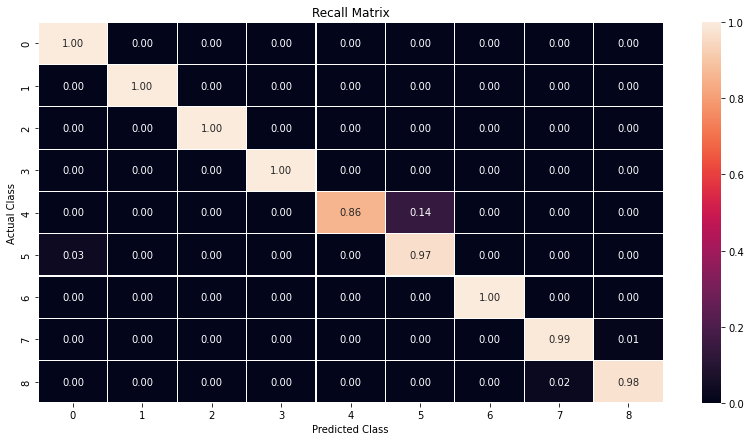

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       247
           1       1.00      1.00      1.00       396
           2       1.00      1.00      1.00       471
           3       1.00      1.00      1.00        76
           4       1.00      0.86      0.92         7
           5       0.99      0.97      0.98       120
           6       1.00      1.00      1.00        64
           7       0.98      0.99      0.98       196
           8       0.99      0.98      0.98       162

    accuracy                           0.99      1739
   macro avg       0.99      0.98      0.98      1739
weighted avg       0.99      0.99      0.99      1739


Test
Logloss (Test): 0.021 for best param: 5
The % of missclassified points in test data: 0.28%
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


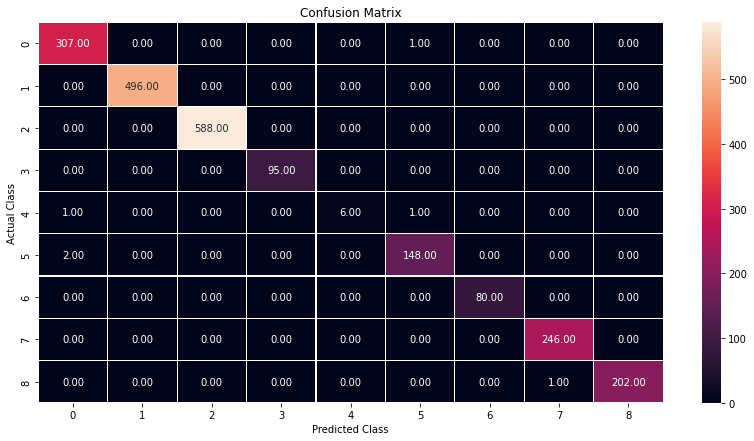

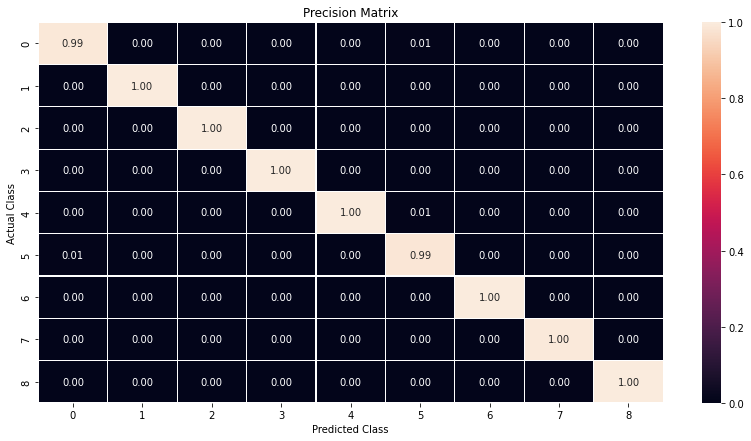

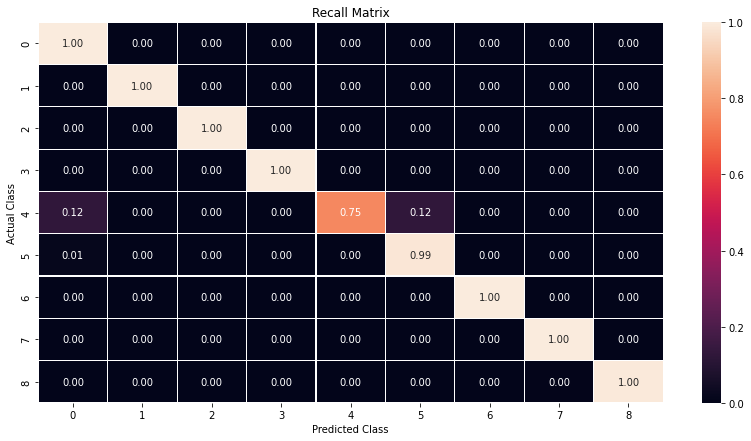

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       308
           1       1.00      1.00      1.00       496
           2       1.00      1.00      1.00       588
           3       1.00      1.00      1.00        95
           4       1.00      0.75      0.86         8
           5       0.99      0.99      0.99       150
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00       246
           8       1.00      1.00      1.00       203

    accuracy                           1.00      2174
   macro avg       1.00      0.97      0.98      2174
weighted avg       1.00      1.00      1.00      2174



In [42]:
estimators_params = [10, 50, 100, 500, 1000, 2000]
gb_train_loss, gb_cv_loss, gb_test_loss = build_gb_classifier(X_train=X_train,
                                                              X_cv=X_cv,
                                                              X_test=X_test,
                                                              y_train=y_train,
                                                              y_cv=y_cv,
                                                              y_test=y_test,
                                                              estimators_params=estimators_params)

Report.

In [43]:
from tabulate import tabulate

In [45]:
all_model_names = ["DummyClassifier", "KNeighborsClassifier", "LogisticRegression", "RandomForestClassifier", "XGBClassifier"]
all_train_losses = [rm_train_loss, knn_train_loss, lr_train_loss, rf_train_loss, gb_train_loss]
all_cv_losses = [rm_cv_loss, knn_cv_loss, lr_cv_loss, rf_cv_loss, gb_cv_loss]
all_test_losses = [rm_test_loss, knn_test_loss, lr_test_loss, rf_test_loss, gb_test_loss]

In [47]:
report_df = pd.DataFrame()
report_df['Model'] = all_model_names
report_df['Train Loss'] = all_train_losses
report_df['CV Loss'] = all_cv_losses
report_df['Test Loss'] = all_test_losses

In [48]:
report_table = tabulate(tabular_data=report_df, headers='keys', tablefmt='psql')
print(report_table)

+----+------------------------+--------------+-----------+-------------+
|    | Model                  |   Train Loss |   CV Loss |   Test Loss |
|----+------------------------+--------------+-----------+-------------|
|  0 | DummyClassifier        |        2.197 |     2.197 |       2.197 |
|  1 | KNeighborsClassifier   |        0.103 |     0.147 |       0.139 |
|  2 | LogisticRegression     |        0.161 |     0.186 |       0.189 |
|  3 | RandomForestClassifier |        0.013 |     0.036 |       0.031 |
|  4 | XGBClassifier          |        0.011 |     0.043 |       0.021 |
+----+------------------------+--------------+-----------+-------------+


Conslusion.

1. From the above tabular report, we see that all the models are performing better compared to our `DummyClassifier`. We use this random model as a benchmark to determine the performance of our main models. Since our performance metric is multi-class logloss, we cannot say which value is better as there is no upper-bound for that metric.
2. The models such as `RandomForestClassifier` and `XGBClassifier` are performing way better.

End of the file.